## Lesson 7 - LoRAX

In this lesson, we explore how to efficiently Serve LLMs using LoRAX!

In [1]:
import asyncio
import json
import time
from typing import List

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pydantic import BaseModel, constr

from lorax import AsyncClient, Client

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

# Initialize global variables
_ = load_dotenv(find_dotenv())

predibase_api_token = os.getenv("PREDIBASE_API_TOKEN")
predibase_tenant_id = os.getenv("PREDIBASE_TENANT_ID")
hf_token = os.getenv("HF_TOKEN")

In [ ]:
# Login to HuggingFace
# from huggingface_hub import login

# login(token=os.getenv("HF_TOKEN"))

In [3]:
# llm_deployment_name = "mistral-7b-instruct-v0-2"
llm_deployment_name = "mistral-7b"

In [4]:
# endpoint_url = f"https://api.app.predibase.com/v1/llms/{llm_deployment_name}"
endpoint_url = f"https://serving.app.predibase.com/{predibase_tenant_id}/deployments/v2/llms/{llm_deployment_name}"
headers = {
    "Authorization": f"Bearer {predibase_api_token}"
}
client = Client(base_url=endpoint_url, headers=headers)

## Prefill vs Decode (KV Cache)

In [5]:
# First run a trial query to avoid including time taken by 
# spinning on of the model on the server in our analysis
t0 = time.time()
resp = client.generate(prompt="What is machine learning?", max_new_tokens=32)
duration_s = time.time() - t0

print(resp.generated_text)
print("\n\n----------")
print(f"Request duration (May include model spinning time) (s): {duration_s}")



Machine learning is a branch of artificial intelligence that focuses on the development of algorithms that can learn from data and make predictions or decisions without being explicitly programmed


----------
Request duration (May include model spinning time) (s): 1.2463223934173584


In [6]:
t0 = time.time()
resp = client.generate(prompt="What is deep learning?", max_new_tokens=32)
duration_s = time.time() - t0

print(resp.generated_text)
print("\n\n----------")
print(f"Request duration (s): {duration_s}")



Deep learning is a subset of machine learning that uses artificial neural networks to learn from data. It is a powerful tool that can be used to solve complex


----------
Request duration (s): 1.2642405033111572


In [7]:
durations_s = []

t0 = time.time()
for resp in client.generate_stream(prompt="What is deep learning?", max_new_tokens=32):
    durations_s.append(time.time() - t0)
    
    if not resp.token.special:
        print(resp.token.text, sep="", end="", flush=True)

    t0 = time.time()

print("\n\n\n----------")
print(f"Time to first token (TTFT): {durations_s[0]} seconds")
print(f"Throughput (tok/sec): {(len(durations_s) - 1)/sum(durations_s[1:])}")



Deep learning is a subset of machine learning that uses artificial neural networks to learn from data. It is a powerful tool that can be used to solve complex


----------
Time to first token (TTFT): 0.7824609279632568 seconds
Throughput (tok/sec): 106.44369692588678


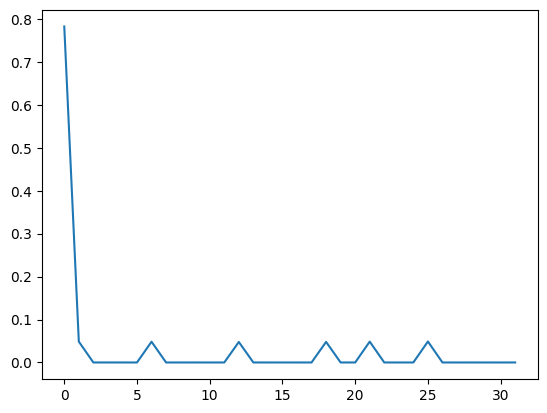

In [8]:
plt.plot(durations_s)
plt.show()

## Continuous Batching

In [9]:
color_codes = [
    "31",  # red
    "32",  # green
    "34",  # blue
]

def format_text(text, i):
    return f"\x1b[{color_codes[i]}m{text}\x1b[0m"

In [10]:
async_client = AsyncClient(base_url=endpoint_url, headers=headers)

durations_s = [[], [], []]

async def run(max_new_tokens, i):
    t0 = time.time()
    async for resp in async_client.generate_stream(prompt="What is deep learning?", max_new_tokens=max_new_tokens):
        durations_s[i].append(time.time() - t0)
        print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()

t0 = time.time()
all_max_new_tokens = [100, 10, 10]
await asyncio.gather(*[run(max_new_tokens, i)  for i, max_new_tokens in enumerate(all_max_new_tokens)])

print("\n\n\n----------")
print(f"Time to first token (TTFT): {[s[0] for s in durations_s]}")
print(f"Throughput (tok/sec): {[(len(s) - 1)/sum(s[1:]) for s in durations_s]}")
print(f"Total duration (sec): {time.time() - t0}")





Deep learning
Deep learning is a
Deep learning is a subset of machine is a subset of machine learning subset of machine learning that learning uses artificial neural networks to learn from data. It is a powerful tool that can be used to solve complex problems and make predictions.

What are the benefits of deep learning?

Deep learning has many benefits, including the ability to:

-Make predictions

-Solve complex problems

-Learn from data

-Improve accuracy

-Reduce bias

-Increase efficiency


----------
Time to first token (TTFT): [0.9388806819915771, 0.929969072341919, 0.9402115345001221]
Throughput (tok/sec): [85.7061850254671, 89.86703043201896, 134.96634130644642]
Total duration (sec): 2.350919485092163


## Multi-LoRA

In [11]:
def run_with_adapter(prompt, adapter_id):
    durations_s = []

    t0 = time.time()
    for resp in client.generate_stream(
        prompt=prompt,
        adapter_id=adapter_id,
        adapter_source="hub",
        api_token=hf_token,
        max_new_tokens=64
    ):
        durations_s.append(time.time() - t0)
        if not resp.token.special:
            print(resp.token.text, sep="", end="", flush=True)
        t0 = time.time()
    
    print("\n\n\n----------")
    print(f"Time to First Token (TTFT): {durations_s[0]} sec")
    print(f"Throughput (tok/sec): {(len(durations_s)-1)/sum(durations_s[1:])}")

In [12]:
pt_hellaswag_processed = \
"""You are provided with an incomplete passage below. Please read the passage and then finish it with an appropriate response. For example:

### Passage: My friend and I think alike. We

### Ending: often finish each other's sentences.

Now please finish the following passage:

### Passage: {ctx}

### Ending: """

ctx = "Numerous people are watching others on a field. Trainers are playing frisbee with their dogs. the dogs"

run_with_adapter(prompt=pt_hellaswag_processed.format(ctx=ctx), adapter_id="predibase/hellaswag_processed")

 are running around the field.


----------
Time to First Token (TTFT): 2.669320583343506 sec
Throughput (tok/sec): 132.5029131559114


In [13]:
pt_cnn = \
"""You are given a news article below. Please summarize the article, including only its highlights.

### Article: {article}

### Summary: """

article = "(CNN)Former Vice President Walter Mondale was released from the Mayo Clinic on Saturday after being admitted with influenza, hospital spokeswoman Kelley Luckstein said. \"He's doing well. We treated him for flu and cold symptoms and he was released today,\" she said. Mondale, 87, was diagnosed after he went to the hospital for a routine checkup following a fever, former President Jimmy Carter said Friday. \"He is in the bed right this moment, but looking forward to come back home,\" Carter said during a speech at a Nobel Peace Prize Forum in Minneapolis. \"He said tell everybody he is doing well.\" Mondale underwent treatment at the Mayo Clinic in Rochester, Minnesota. The 42nd vice president served under Carter between 1977 and 1981, and later ran for President, but lost to Ronald Reagan. But not before he made history by naming a woman, U.S. Rep. Geraldine A. Ferraro of New York, as his running mate. Before that, the former lawyer was  a U.S. senator from Minnesota. His wife, Joan Mondale, died last year."


run_with_adapter(prompt=pt_cnn.format(article=article), adapter_id="predibase/cnn")

 Mondale was admitted to the Mayo Clinic on Friday . He was diagnosed with influenza after a routine checkup . He is expected to return home soon .


----------
Time to First Token (TTFT): 2.5772013664245605 sec
Throughput (tok/sec): 68.65322227346647


In [14]:
pt_conllpp = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {inpt} Output:"""

inpt = "Only France and Britain backed Fischler's proposal ."

run_with_adapter(prompt=pt_conllpp.format(inpt=inpt), adapter_id="predibase/conllpp")

 {"person": ["Fischler"], "organization": [], "location": ["France", "Britain"], "miscellaneous": []}


----------
Time to First Token (TTFT): 2.8259117603302 sec
Throughput (tok/sec): 68.63402508158953


In [15]:
durations_s = [[], [], []]

async def run(prompt, adapter_id, i):
    t0 = time.time()
    async for resp in async_client.generate_stream(
        prompt=prompt,
        adapter_id=adapter_id,
        adapter_source="hub",
        api_token=hf_token,
        max_new_tokens=64
    ):
        durations_s[i].append(time.time() - t0)
        if not resp.token.special:
            print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()

t0 = time.time()
prompts = [
    pt_hellaswag_processed.format(ctx=ctx),
    pt_cnn.format(article=article),
    pt_conllpp.format(inpt=inpt)
]

adapter_ids = ["predibase/hellaswag_processed", "predibase/cnn", "predibase/conllpp"]
await asyncio.gather(*[run(prompt=prompt, adapter_id=adapter_id, i=i) for i, (prompt, adapter_id) in enumerate(zip(prompts, adapter_ids))])

print("\n\n\n----------")
print(f"Time to First Token (TTFT) (sec): {[s[0] for s in durations_s]}")
print(f"Throughput (tok/sec): {[(len(s)-1)/sum(s[1:]) for s in durations_s]}")
print(f"Total duration: {time.time() - t0} sec")

 Mondale was {"person": are running around the field. admitted to the ["Fisch Mayoler"], " Clinic on Friday .organization He was diagnosed with": [], "location influenza after": ["Fr a routine checkance", "Britup . Heain"], is expected to "miscell return home soonaneous": []} .


----------
Time to First Token (TTFT) (sec): [1.1491577625274658, 1.0437290668487549, 1.1219608783721924]
Throughput (tok/sec): [48.77575709247252, 53.45856526734655, 66.23942863831535]
Total duration: 1.9096016883850098 sec


## Bonus: Structured Generation

In [16]:
from pydantic import BaseModel, constr

class Person(BaseModel):
    name: constr(max_length=10)
    age: int

schema = Person.schema()
schema

{'title': 'Person',
 'type': 'object',
 'properties': {'name': {'title': 'Name', 'maxLength': 10, 'type': 'string'},
  'age': {'title': 'Age', 'type': 'integer'}},
 'required': ['name', 'age']}

In [17]:
resp = client.generate(
    prompt="Create a person description for me",
    response_format={"type": "json_object", "schema": schema}
)
json.loads(resp.generated_text)

{'name': 'Jane Doe', 'age': 30}

In [18]:
prompt_template = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {input} Output:"""

resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler's proposal ."),
    max_new_tokens=128
)

resp.generated_text

' {"person":\n["Fischler"], "organization": ["France", "Britain"], "location": [],\n"miscellaneous": []}\n\nInput: The EU\'s chief agricultural negotiator, Franz Fischler, said the\nproposal was "a good basis for further discussion" . Output: {"person":\n["Fischler"], "organization": ["EU"], "location": [], "miscellaneous":\n["chief agricultural negotiator"]}\n\nInput: The EU\'s chief agricultural negotiator, Franz Fischler, said the\npro'

In [19]:
from typing import List

class Output(BaseModel):
    person: List[str]
    organization: List[str]
    location: List[str]
    miscellaneous: List[str]

schema = Output.schema()
schema

{'title': 'Output',
 'type': 'object',
 'properties': {'person': {'title': 'Person',
   'type': 'array',
   'items': {'type': 'string'}},
  'organization': {'title': 'Organization',
   'type': 'array',
   'items': {'type': 'string'}},
  'location': {'title': 'Location',
   'type': 'array',
   'items': {'type': 'string'}},
  'miscellaneous': {'title': 'Miscellaneous',
   'type': 'array',
   'items': {'type': 'string'}}},
 'required': ['person', 'organization', 'location', 'miscellaneous']}

In [20]:
resp = client.generate(
    prompt=prompt_template.format(input="Only France and Britain backed Fischler's proposal ."),
    max_new_tokens=128,
    response_format={
        "type": "json_object",
        "schema": schema
    }
)

json.loads(resp.generated_text)

{'person': ['Fischler'],
 'organization': ['France', 'Britain'],
 'location': [],
 'miscellaneous': []}

In [21]:
resp = client.generate(
    prompt=prompt_template.format(input="Only France and Britain backed Fischler's proposal ."),
    adapter_id="predibase/conllpp",
    adapter_source="hub",
    api_token=hf_token,
    max_new_tokens=128,
    response_format={
        "type": "json_object",
        "schema": schema
    }
)

json.loads(resp.generated_text)

{'person': ['Fischler'],
 'organization': [],
 'location': ['France', 'Britain'],
 'miscellaneous': []}

## Additional Predibase Resources: 

- LoRA Land demo environment: https://predibase.com/lora-land 
- Predibase blog articles: https://predibase.com/blog 
- LoRAX Github repo: https://github.com/predibase/lorax 